# KEPLER‑10

Este notebook presenta el análisis de la estrella **Kepler‑10** y sus dos planetas confirmados (Kepler‑10b y Kepler‑10c), usando datos observacionales y fórmulas astrofísicas.  
Se calcula la zona habitable, se analiza la curva de luz, y se comparan parámetros estimados con los valores reales reportados por la NASA Exoplanet Archive.


In [2]:
!pip install lightkurve
!pip install pandas

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.6/199.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 148.4 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=c1ceda3ac9285a12a21e02d837fc6bfb9557e88a1fbc9dcef80da5895b7290e1
  Stored in directory: /root/.cache/pip/wheels/71/ae/f7/5b7e1e16a133d094431428169e9a8d9f750afe5459f0333c9b
  Created wheel for memoizatio

In [3]:
%matplotlib inline
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Constantes físicas ---
G = 6.67430e-11         # m^3 kg^-1 s^-2
M_sun = 1.988475e30     # kg
R_sun = 695700e3        # m
R_ea = 6378137.0        # m
UA = 149.597870700e9    # m
dy2sec = 86400          # s

/usr/local/lib/python3.11/dist-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


## 1. Parámetros Estelares

Se definen los parámetros físicos de Kepler‑10 con base en publicaciones de la NASA y literatura científica revisada.  
Incluye: masa, radio, tipo espectral, edad y temperatura efectiva.


In [4]:
# --- Parámetros estelares completos (NASA / Wikipedia) ---
Star = 'Kepler-10'
M_star = 0.8950 * M_sun
R_star = 1.065 * R_sun
T_star = 5708
age_star = 10.6
spectral_type = 'G2V'
logg_star = 4.35

print(f"Estrella: {Star} (tipo {spectral_type}), Edad ≈ {age_star} Gyr, Teff ≈ {T_star} K")

Estrella: Kepler-10 (tipo G2V), Edad ≈ 10.6 Gyr, Teff ≈ 5708 K


## 2. Zona Habitable

Se estima la zona habitable (ZH) del sistema con base en la luminosidad estelar, utilizando el modelo conservador de Kopparapu et al. (2013).  
Esto permite evaluar si alguno de los planetas podría encontrarse dentro de la zona donde es posible la presencia de agua líquida.


In [5]:
# --- Zona habitable basada en luminosidad ---
L_star = 1.004
HZ_inner = np.sqrt(L_star / 1.1)
HZ_outer = np.sqrt(L_star / 0.53)
print(f"Zona habitable estimada: {HZ_inner:.2f} – {HZ_outer:.2f} UA")

Zona habitable estimada: 0.96 – 1.38 UA


## 3. Diagrama HR

Se representa la ubicación aproximada de Kepler‑10 en el diagrama de Hertzsprung-Russell (HR), usando log(g) frente a temperatura efectiva (Teff).  
Esto confirma su naturaleza como estrella tipo G de secuencia principal (similar al Sol).


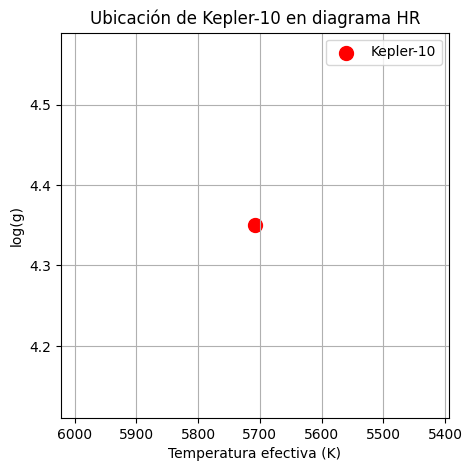

In [6]:
# --- Diagrama HR (log(g) vs Teff) ---
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(T_star, logg_star, c='red', s=100, label=Star)
ax.invert_xaxis()
ax.set_xlabel("Temperatura efectiva (K)")
ax.set_ylabel("log(g)")
ax.set_title("Ubicación de Kepler-10 en diagrama HR")
ax.legend()
ax.grid(True)
plt.show()

## 4. Curva de Luz del Sistema

Se descarga y procesa la curva de luz de la estrella desde la misión Kepler, eliminando valores atípicos y normalizando el flujo.  
Posteriormente se aplica el método BLS (Box Least Squares) para detectar señales de tránsito.


<Axes: title={'center': 'Curva de luz limpia — Kepler-10'}, xlabel='Time - 2454833 [BKJD days]', ylabel='Flujo normalizado'>

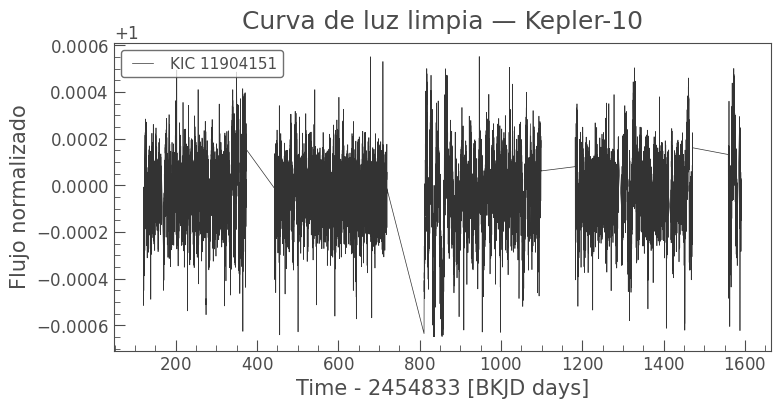

In [7]:
# --- Curva de luz procesada ---
search = lk.search_lightcurve(Star, author='Kepler', cadence='long')
lc = search.download_all().stitch().flatten(window_length=901).remove_outliers()
lc.plot(title=f"Curva de luz limpia — {Star}", ylabel="Flujo normalizado")

## 5. Análisis de los Planetas b y c

Usando los resultados de BLS, se estiman los radios planetarios (a partir de la profundidad del tránsito) y los semiejes mayores (por la tercera ley de Kepler).  
Se comparan los valores estimados con los reportados oficialmente por la NASA.


In [8]:
# --- Planetas b y c: detección con BLS ---
def analyze_planet(lc_in, pmin, pmax, label):
    period_array = np.linspace(pmin, pmax, 10000)
    bls = lc_in.to_periodogram('bls', period=period_array, frequency_factor=500)
    P = bls.period_at_max_power.value
    depth = bls.depth_at_max_power.value
    R = np.sqrt(depth) * R_star / R_ea
    a = ((G * M_star * (P*dy2sec)**2) / (4*np.pi**2))**(1/3) / UA
    return bls, P, depth, R, a

bls_b, P_b, depth_b, Rb_est, a_b = analyze_planet(lc, 0.64, 1.0, 'b')
lc_no_b = lc[~bls_b.get_transit_mask(period=P_b, transit_time=bls_b.transit_time_at_max_power.value, duration=bls_b.duration_at_max_power.value)]
bls_c, P_c, depth_c, Rc_est, a_c = analyze_planet(lc_no_b, 35, 52, 'c')

## 6. Tabla Comparativa

Se presenta una tabla con los siguientes parámetros para cada planeta:
- Periodo orbital estimado vs. real
- Radio estimado vs. real
- Semieje mayor estimado vs. real  
Además, se indica si el planeta se encuentra dentro de la zona habitable del sistema.


In [9]:
# --- Valores reales de NASA ---
Rb_real, Rc_real = 1.47, 2.35
ab_real, ac_real = 0.01684, 0.2410
Pb_real, Pc_real = 0.83749, 45.2943

# --- Tabla resumen ---
df = pd.DataFrame([
    ["Kepler-10 b", P_b, Pb_real, abs(P_b-Pb_real), Rb_est, Rb_real, abs(Rb_est-Rb_real), a_b, ab_real, abs(a_b-ab_real), HZ_inner<=a_b<=HZ_outer],
    ["Kepler-10 c", P_c, Pc_real, abs(P_c-Pc_real), Rc_est, Rc_real, abs(Rc_est-Rc_real), a_c, ac_real, abs(a_c-ac_real), HZ_inner<=a_c<=HZ_outer]
], columns=["Planeta","P_estim","P_real","ΔP","R_estim","R_real","ΔR","a_estim","a_real","Δa","En_HZ"])
df.set_index("Planeta", inplace=True)
display(df)

,P_estim,P_real,ΔP,R_estim,R_real,ΔR,a_estim,a_real,Δa,En_HZ
Planeta,,,,,,,,,,
Kepler-10 b,0.837480,0.83749,0.000010,1.289510,1.47,0.180490,0.016757,0.01684,0.000083,False
Kepler-10 c,45.292829,45.29430,0.001471,2.327102,2.35,0.022898,0.239644,0.24100,0.001356,False


## 7. Visualización Orbital

Se grafican las órbitas estimadas y reales de ambos planetas, así como la zona habitable, con el objetivo de representar gráficamente la arquitectura del sistema Kepler‑10.


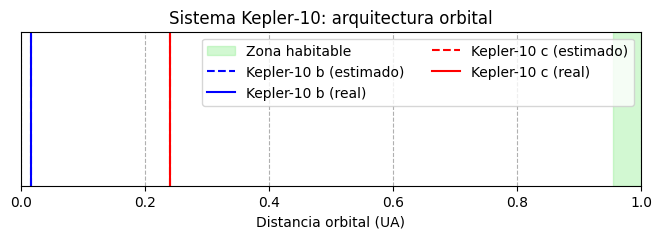

In [10]:
# --- Gráficos ilustrativos ---
fig, ax = plt.subplots(figsize=(8,2))
ax.axvspan(HZ_inner, HZ_outer, color='lightgreen', alpha=0.4, label='Zona habitable')
for planet, col in zip(df.index, ['blue','red']):
    ax.axvline(df.loc[planet,'a_estim'], color=col, linestyle='--', label=f"{planet} (estimado)")
    ax.axvline(df.loc[planet,'a_real'], color=col, label=f"{planet} (real)")
ax.set_xlim(0, 1.0)
ax.set_xlabel("Distancia orbital (UA)")
ax.set_yticks([])
ax.set_title("Sistema Kepler‑10: arquitectura orbital")
ax.legend(ncol=2)
plt.grid(axis='x', linestyle='--')
plt.show()

## 8. Comparación de Radios

Se genera un gráfico de barras para visualizar la diferencia entre los radios estimados y los valores reales de los planetas Kepler‑10b y Kepler‑10c, expresados en radios terrestres (R⊕).


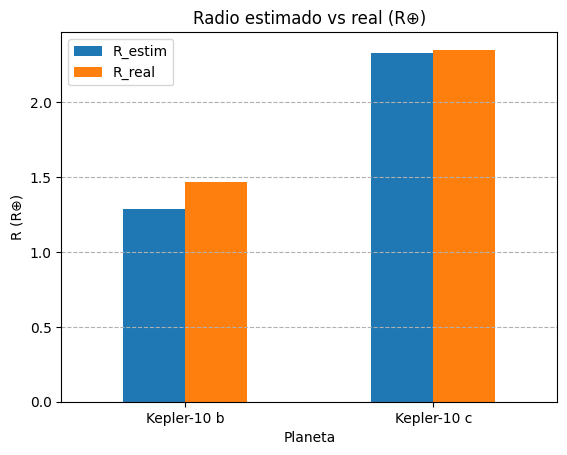

In [11]:
# --- Radios comparativas ---
df[['R_estim','R_real']].plot.bar(rot=0, title="Radio estimado vs real (R⊕)", ylabel="R (R⊕)")
plt.grid(axis='y', linestyle='--')
plt.show()